In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycrfsuite

from preprocessing import read_dataset
from preprocessing import Tokenization, StopWordsRemover, Lemmatization, RoofRemoval, SpellingCorrection
from preprocessing import GibberishDetector, TokenGrouping, TokenDictionary

from baseline import evaluate_solution
from csv_parser import split_train_test

In [2]:
def annotate_bar(ax, annotations):
    ax.margins(0.1)
    for p, ann in zip(ax.patches, annotations): 
        ax.annotate(ann, 
                    (p.get_x()+p.get_width()/2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points')
        
def annotate_bar_v2(ax, annotations, heights, offset=20):
    ax.margins(0.1)
    for i, (ann, h) in enumerate(zip(annotations, heights)):
        ax.text(i, h + offset, ann, ha='center')

In [3]:
# Read data
dataset_path = 'data/discussion_data.csv'
df = read_dataset(dataset_path)
df.head()

,School,Cohort,Book ID,Topic,Bookclub,User ID,Name,Message,Translation,Message Time,Is Answer,Page,Book relevance,Type,Category,CategoryBroad
0,OŠ Ketteja in Murna,MumaD,8,Kako bi lahko Cefizelj pobegnil policistu še n...,Book Club One,1382,MumaD8,gremo se pogovarjati,Let's talk,2019-06-18 05:16:16 AM,No,4,No,S,CE,C
1,OŠ Ketteja in Murna,MumaD,8,Kako bi lahko Cefizelj pobegnil policistu še n...,Book Club One,1392,MumaD18,Kip je to,This is a statue,2019-06-18 05:17:29 AM,No,4,No,S,CO,C
2,OŠ Ketteja in Murna,MumaD,8,Kako bi lahko Cefizelj pobegnil policistu še n...,Book Club One,1392,MumaD18,Kdo je to jaz sem tara,Who is this I am Tara (girl's name),2019-06-18 05:17:59 AM,No,4,No,Q,IQ,I
3,OŠ Ketteja in Murna,MumaD,8,Kako bi lahko Cefizelj pobegnil policistu še n...,Book Club One,1382,MumaD8,kaj kip,what statue,2019-06-18 05:18:58 AM,No,4,No,S,CO,C
4,OŠ Ketteja in Murna,MumaD,8,Kako bi lahko Cefizelj pobegnil policistu še n...,Book Club One,1382,MumaD8,gremo ven,let's go outside,2019-06-18 05:19:24 AM,No,4,No,S,CO,C


In [4]:
df['Message Time'] = pd.to_datetime(df['Message Time'])

## Messages

In [5]:
category_names = {
    'C': 'Chatting', 
    'D': 'Discussion', 
    'I': 'Identity', 
    'O': 'Other', 
    'M': 'Moderating', 
    'S': 'Switching'
}

In [6]:
class_df = pd.DataFrame({'messages': df.CategoryBroad.value_counts()})
class_df

,messages
C,1353
D,1058
I,402
O,267
M,154
S,32


In [7]:
class_df.index = [category_names[cat] for cat in class_df.index]
class_df['rel'] = class_df['messages']/class_df['messages'].sum()
class_df

,messages,rel
Chatting,1353,0.414268
Discussion,1058,0.323944
Identity,402,0.123086
Other,267,0.081751
Moderating,154,0.047152
Switching,32,0.009798


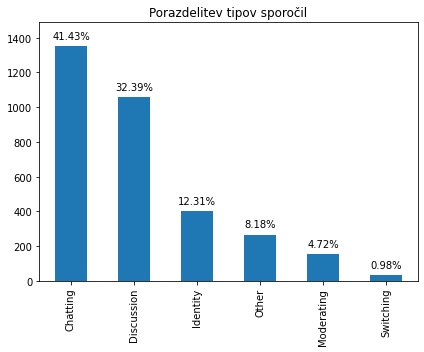

In [8]:
ax = class_df['messages'].plot.bar(title='Porazdelitev tipov sporočil', figsize=(6,5))
percentages = [f'{p:.2f}%' for p in (class_df['rel'] * 100)]
annotate_bar(ax, percentages)

plt.tight_layout()
plt.savefig('figures/categories.pdf')

## Schools

In [9]:
schools_df = df.groupby(['School', 'CategoryBroad'])['School'].count().unstack('CategoryBroad')
schools_df.columns = [category_names[cat] for cat in schools_df.columns]
schools_df

,Chatting,Discussion,Identity,Moderating,Other,Switching
School,,,,,,
OŠ Alojzija Šuštarja,57,94,13,14,12,0
OŠ Franca Rozmana Staneta,346,199,71,6,11,15
OŠ Ketteja in Murna,206,110,97,8,100,0
OŠ Koseze,91,205,4,8,2,14
OŠ Nove Fužine,118,89,71,47,21,1
OŠ Valentina Vodnika,123,157,60,2,42,0
OŠ Vide Pregarc,215,56,73,11,39,1
OŠ Vižmarje - Brod,197,148,13,58,40,1


In [10]:
schools_df_sum = pd.DataFrame({'count': df['School'].value_counts()})
schools_df_sum['rel'] = schools_df_sum['count']/schools_df_sum['count'].sum()
schools_df_sum

,count,rel
OŠ Franca Rozmana Staneta,648,0.198408
OŠ Ketteja in Murna,521,0.159522
OŠ Vižmarje - Brod,457,0.139927
OŠ Vide Pregarc,395,0.120943
OŠ Valentina Vodnika,384,0.117575
OŠ Nove Fužine,347,0.106246
OŠ Koseze,324,0.099204
OŠ Alojzija Šuštarja,190,0.058175


In [11]:
# Sorted
schools_df = schools_df.loc[schools_df_sum.index]

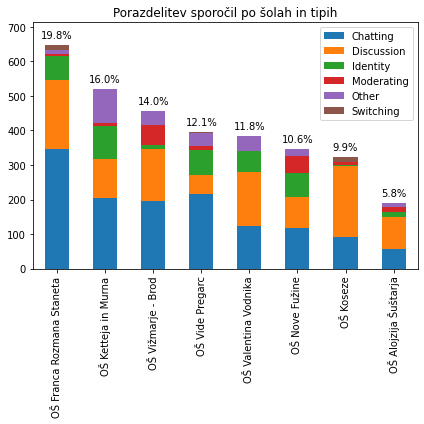

In [12]:
ax = schools_df.plot.bar(
    stacked=True, title='Porazdelitev sporočil po šolah in tipih', figsize=(6,6))

percentages = [f'{p:.1f}%' for p in (schools_df_sum['rel'] * 100)]
heights = schools_df_sum['count']
annotate_bar_v2(ax, percentages, heights)

plt.tight_layout()
plt.savefig('figures/schools.pdf')